In this notebook, I am trying to come up with a quick way to visualize UMAPs in a static setting.

# Plotting Static Umaps

In [1]:
import hyrax

In [2]:
from pathlib import Path
import re

def extract_umap_info(x,y,base_directory="/mmfs1/gscratch/dirac/aritrag/hyrax_comcam_dp1_runs"):
  """Extract UMAP directory from 3dumap output file."""

  # Construct paths
  run_dir = Path(base_directory) / f"run{x}"
  dumap_name = f"udb{x}_{y}"

  dumap_output_file = run_dir / f"{dumap_name}.txt"
  dumap_toml_file = run_dir / f"{dumap_name}.toml"
    
  try:
      with open(dumap_output_file, 'r') as f:
          content = f.read()

      # Look for the UMAP results save pattern
      pattern = r'Saving UMAP results to (.+)'
      match = re.search(pattern, content)

      if match:
          umap_dir = match.group(1).strip()
          return umap_dir, dumap_toml_file
      else:
          raise ValueError(f"Could not find UMAP directory in {dumap_output_file}")

  except FileNotFoundError:
      raise FileNotFoundError(f"3dumap output file not found: {dumap_output_file}")

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import logging

def plot_umap_simple(ax, config=None, input_dir=None, alpha=0.6, s=1, color=None,
                       color_column=None, vmin=None, vmax=None, log_colorbar=False,
                       density=False, cmap='viridis', title=None, supress_hyrax_logs=False):
  """
  Create a simple static matplotlib scatter plot of 2D UMAP results on provided axis.
  
  Parameters
  ----------
  ax : matplotlib.axes.Axes
      The axis to plot on
  config: 
      Hyrax config object
  input_dir : str or Path, optional
      Directory containing UMAP results. If None, uses most recent in current results dir.
  alpha : float, default 0.6
      Point transparency
  s : float, default 1
      Point size
  color : array-like, optional
      Color values for scatter plot. If provided, overrides color_column.
  color_column : str, optional
      Name of catalog column to use for coloring points
  vmin : float, optional
      Minimum value for color scaling
  vmax : float, optional
      Maximum value for color scaling
  log_colorbar : bool, default False
      If True, use logarithmic color scaling
  density : bool, default False
      If True, plot hexbin density plot instead of scatter
  cmap : str, default 'viridis'
      Colormap name
  title : str, default None
      Plot title
      
  Returns
  -------
  matplotlib.axes.Axes
      The axis object with the plot
  """

  from hyrax.data_sets.inference_dataset import InferenceDataSet
  from matplotlib.colors import LogNorm, Normalize
      
  # Load UMAP results
  if supress_hyrax_logs is True:
      logging.disable(logging.CRITICAL)
  umap_results = InferenceDataSet(config, results_dir=input_dir, verb="umap")
  logging.disable(logging.NOTSET)
    
  # Extract 2D coordinates
  points = np.array([point.numpy() for point in umap_results])
  x, y = points[:, 0], points[:, 1]

  # Handle color specification
  color_values = None
  colorbar_label = None

  if color is not None:
      # Use provided color array (original behavior)
      color_values = color
      colorbar_label = 'Point Index'
  elif color_column is not None:
      # Get color values from catalog column
      try:
          # Get all available fields to check if column exists
          available_fields = umap_results.metadata_fields()
          if color_column not in available_fields:
              raise ValueError(f"Column '{color_column}' not found in dataset. Available fields: {available_fields}")

          # Get all indices for the dataset
          all_indices = list(range(len(umap_results)))

          # Extract metadata for the specified column
          metadata = umap_results.metadata(all_indices, [color_column])
          color_values = np.array(metadata[color_column])
          colorbar_label = color_column

      except Exception as e:
          print(f"Warning: Could not load column '{color_column}': {e}")
          print("Proceeding without coloring")

  if density:
    # Create hexbin plot
    if color_values is not None:
        # Hexbin with color values - compute mean/median of color values in each bin
        # Determine normalization for color values
        if log_colorbar:
            # Ensure positive values for log scaling
            if np.any(color_values <= 0):
                min_positive = np.min(color_values[color_values > 0]) if np.any(color_values > 0) else 1e-10
                color_values = np.maximum(color_values, min_positive)
                print(f"Warning: Non-positive values found, clamped to {min_positive} for log scaling")

            norm = LogNorm(vmin=vmin, vmax=vmax)
        else:
            norm = Normalize(vmin=vmin, vmax=vmax)

        # Use reduce_C_function to aggregate color values in each hexbin
        hb = ax.hexbin(x, y, C=color_values, gridsize=50, cmap=cmap, norm=norm, reduce_C_function=np.mean)
        cbar = plt.colorbar(hb, ax=ax, label=colorbar_label)

        if log_colorbar:
            cbar.set_label(f'{colorbar_label} (log scale)')
    else:
        # Hexbin with just point density (counts)
        norm = LogNorm() if log_colorbar else None
        hb = ax.hexbin(x, y, gridsize=50, cmap=cmap, norm=norm)
        plt.colorbar(hb, ax=ax, label='Count')
  else:
    # Regular scatter plot
    if color_values is not None:
        # Determine normalization
        if log_colorbar:
            # Ensure positive values for log scaling
            if np.any(color_values <= 0):
                min_positive = np.min(color_values[color_values > 0]) if np.any(color_values > 0) else 1e-10
                color_values = np.maximum(color_values, min_positive)
                print(f"Warning: Non-positive values found, clamped to {min_positive} for log scaling")

            norm = LogNorm(vmin=vmin, vmax=vmax)
        else:
            norm = Normalize(vmin=vmin, vmax=vmax)

        scatter = ax.scatter(x, y, alpha=alpha, s=s, c=color_values, cmap=cmap, norm=norm)
        cbar = plt.colorbar(scatter, ax=ax, label=colorbar_label)
    else:
        scatter = ax.scatter(x, y, alpha=alpha, s=s)


  # Styling
  if title is not None:
      ax.set_title(title)

  return ax

In [18]:
def plot_multiple_umaps(runs, expts, figsize=None, ncols=3, density=False, 
                          cmap='viridis', alpha=0.6, s=1, save_path=None, 
                          suptitle="UMAP Comparisons", dpi=150, supress_hyrax_logs=False,
                          color=None, color_column=None, vmin=None, vmax=None, log_colorbar=False):
      """
      Create a multi-panel plot of UMAP results from multiple run/experiment combinations.
      
      Parameters
      ----------
      runs : array-like
          Array of run numbers
      expts : array-like
          Array of experiment numbers (same length as runs)
      figsize : tuple, optional
          Figure size. If None, calculated based on number of plots
      ncols : int, default 3
          Number of columns in the subplot grid
      density : bool, default False
          If True, plot hexbin density plots instead of scatter
      cmap : str, default 'viridis'
          Colormap name
      alpha : float, default 0.6
          Point transparency (for scatter plots)
      s : float, default 1
          Point size (for scatter plots)
      save_path : str or Path, optional
          Path to save the plot. If None, just displays it
      suptitle : str, default "UMAP Comparisons"
          Overall figure title
      dpi : int, default 150
          DPI for the figure
      color_column : str, optional
          Name of catalog column to use for coloring points
      vmin : float, optional
          Minimum value for color scaling
      vmax : float, optional
          Maximum value for color scaling
      log_colorbar : bool, default False
          If True, use logarithmic color scaling
          
      Returns
      -------
      matplotlib.figure.Figure
          The matplotlib figure object
      """
      import math
      import logging
      from tqdm.notebook import tqdm

      # Ensure runs and expts are the same length
      if len(runs) != len(expts):
          raise ValueError("runs and expts arrays must be the same length")

      n_plots = len(runs)
      nrows = math.ceil(n_plots / ncols)

      # Calculate figure size if not provided
      if figsize is None:
          figsize = (ncols * 4, nrows * 3)

      # Create figure and subplots
      fig, axes = plt.subplots(nrows, ncols, figsize=figsize, dpi=dpi)

      # Handle case where we have only one row or column
      if n_plots == 1:
          axes = [axes]
      elif nrows == 1:
          axes = axes.flatten()
      elif ncols == 1:
          axes = axes.flatten()
      else:
          axes = axes.flatten()

      # Plot each run/experiment combination
      for i, (run, expt) in enumerate(tqdm(zip(runs, expts),total=len(expts))):
          if i >= len(axes):
              break

          ax = axes[i]

          try:
              # Get UMAP info and create config
              umap_dir, config_file = extract_umap_info(run, expt)
              if supress_hyrax_logs is True:
                  logging.disable(logging.CRITICAL)
              h = hyrax.Hyrax(config_file=config_file)
              logging.disable(logging.NOTSET)
              
              # Create title
              title = f"Run {run}, Expt {expt}"

              # Plot on this axis
              plot_umap_simple(ax, config=h.config, input_dir=umap_dir,
                             alpha=alpha, s=s, density=density, cmap=cmap, title=title,
                             supress_hyrax_logs=supress_hyrax_logs,
                             color=color, color_column=color_column, vmin=vmin, vmax=vmax,
                             log_colorbar=log_colorbar)

          except Exception as e:
              # If there's an error, show it on the plot
              ax.text(0.5, 0.5, f"Error loading\nRun {run}, Expt {expt}\n{str(e)}",
                     ha='center', va='center', transform=ax.transAxes)
              ax.set_title(f"Run {run}, Expt {expt} - ERROR")

      # Hide unused subplots
      for i in range(n_plots, len(axes)):
          axes[i].axis('off')

      # Set overall title
      fig.suptitle(suptitle, fontsize=16)

      # Adjust layout
      plt.tight_layout()

      # Save or show
      if save_path:
          plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
      else:
          plt.show()

      return fig


# Plotting UMAPs

In [28]:
run = 4
expt = 12

h = hyrax.Hyrax(config_file=extract_umap_info(run,expt)[1])

[2025-07-22 13:56:42,408 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-07-22 13:56:42,409 hyrax.config_utils:WARNING] Cannot find default_config.toml for torch.
[2025-07-22 13:56:42,409 hyrax.config_utils:WARNING] Cannot find default_config.toml for umap.
[2025-07-22 13:56:42,414 hyrax:INFO] Runtime Config read from: /mmfs1/gscratch/dirac/aritrag/hyrax_comcam_dp1_runs/run4/udb4_12.toml


[2025-07-22 13:57:19,424 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-07-22 13:57:19,471 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /mmfs1/gscratch/scrubbed/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-07-22 13:57:19,976 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-07-22 13:57:19,977 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-07-22 13:57:19,977 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-07-22 13:57:20,182 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-07-2

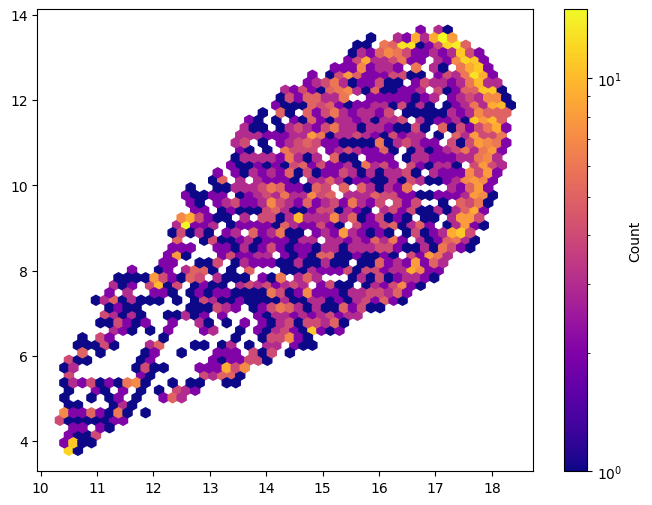

In [30]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

ax = plot_umap_simple(ax, config=h.config,input_dir=extract_umap_info(run,expt)[0], alpha=0.8, s=1, cmap='plasma', density=True,
                     supress_hyrax_logs=False, log_colorbar=True)

[2025-07-22 13:58:17,254 hyrax.data_sets.lsst_dataset:INFO] Did not detect a Butler. You may need to run on the RSP
[2025-07-22 13:58:17,277 hyrax.data_sets.downloaded_lsst_dataset:INFO] Found existing manifest at /mmfs1/gscratch/scrubbed/aritrag/comcam_dp1/ecdfs_objects_public_dp1_34asec/manifest.fits
[2025-07-22 13:58:17,846 hyrax.data_sets.downloaded_lsst_dataset:INFO] Requested bands ['g', 'i', 'r', 'z'] are a subset of available ['g', 'i', 'r', 'u', 'y', 'z']
[2025-07-22 13:58:17,847 hyrax.data_sets.downloaded_lsst_dataset:INFO] Band filtering setup: ['u', 'g', 'r', 'i', 'z', 'y'] -> ['g', 'r', 'i', 'z']
[2025-07-22 13:58:17,847 hyrax.data_sets.downloaded_lsst_dataset:INFO] Tensor indices to extract: [1, 2, 3, 4]
[2025-07-22 13:58:18,045 hyrax.data_sets.downloaded_lsst_dataset:INFO] Current catalog (3391 objects)                            is a subset of existing manifest (494820 objects). Using existing manifest                            with filtering for operations.
[2025-07-2

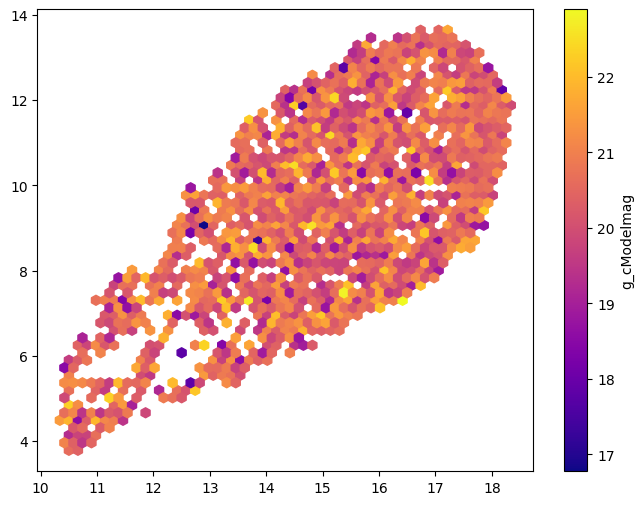

In [32]:
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

ax = plot_umap_simple(ax, config=h.config,input_dir=extract_umap_info(run,expt)[0], alpha=0.8, s=1, cmap='plasma', density=True,
                     supress_hyrax_logs=False, log_colorbar=False, color_column="g_cModelmag")

# HyraxAutoencoderV2 Runs

  0%|          | 0/7 [00:00<?, ?it/s]

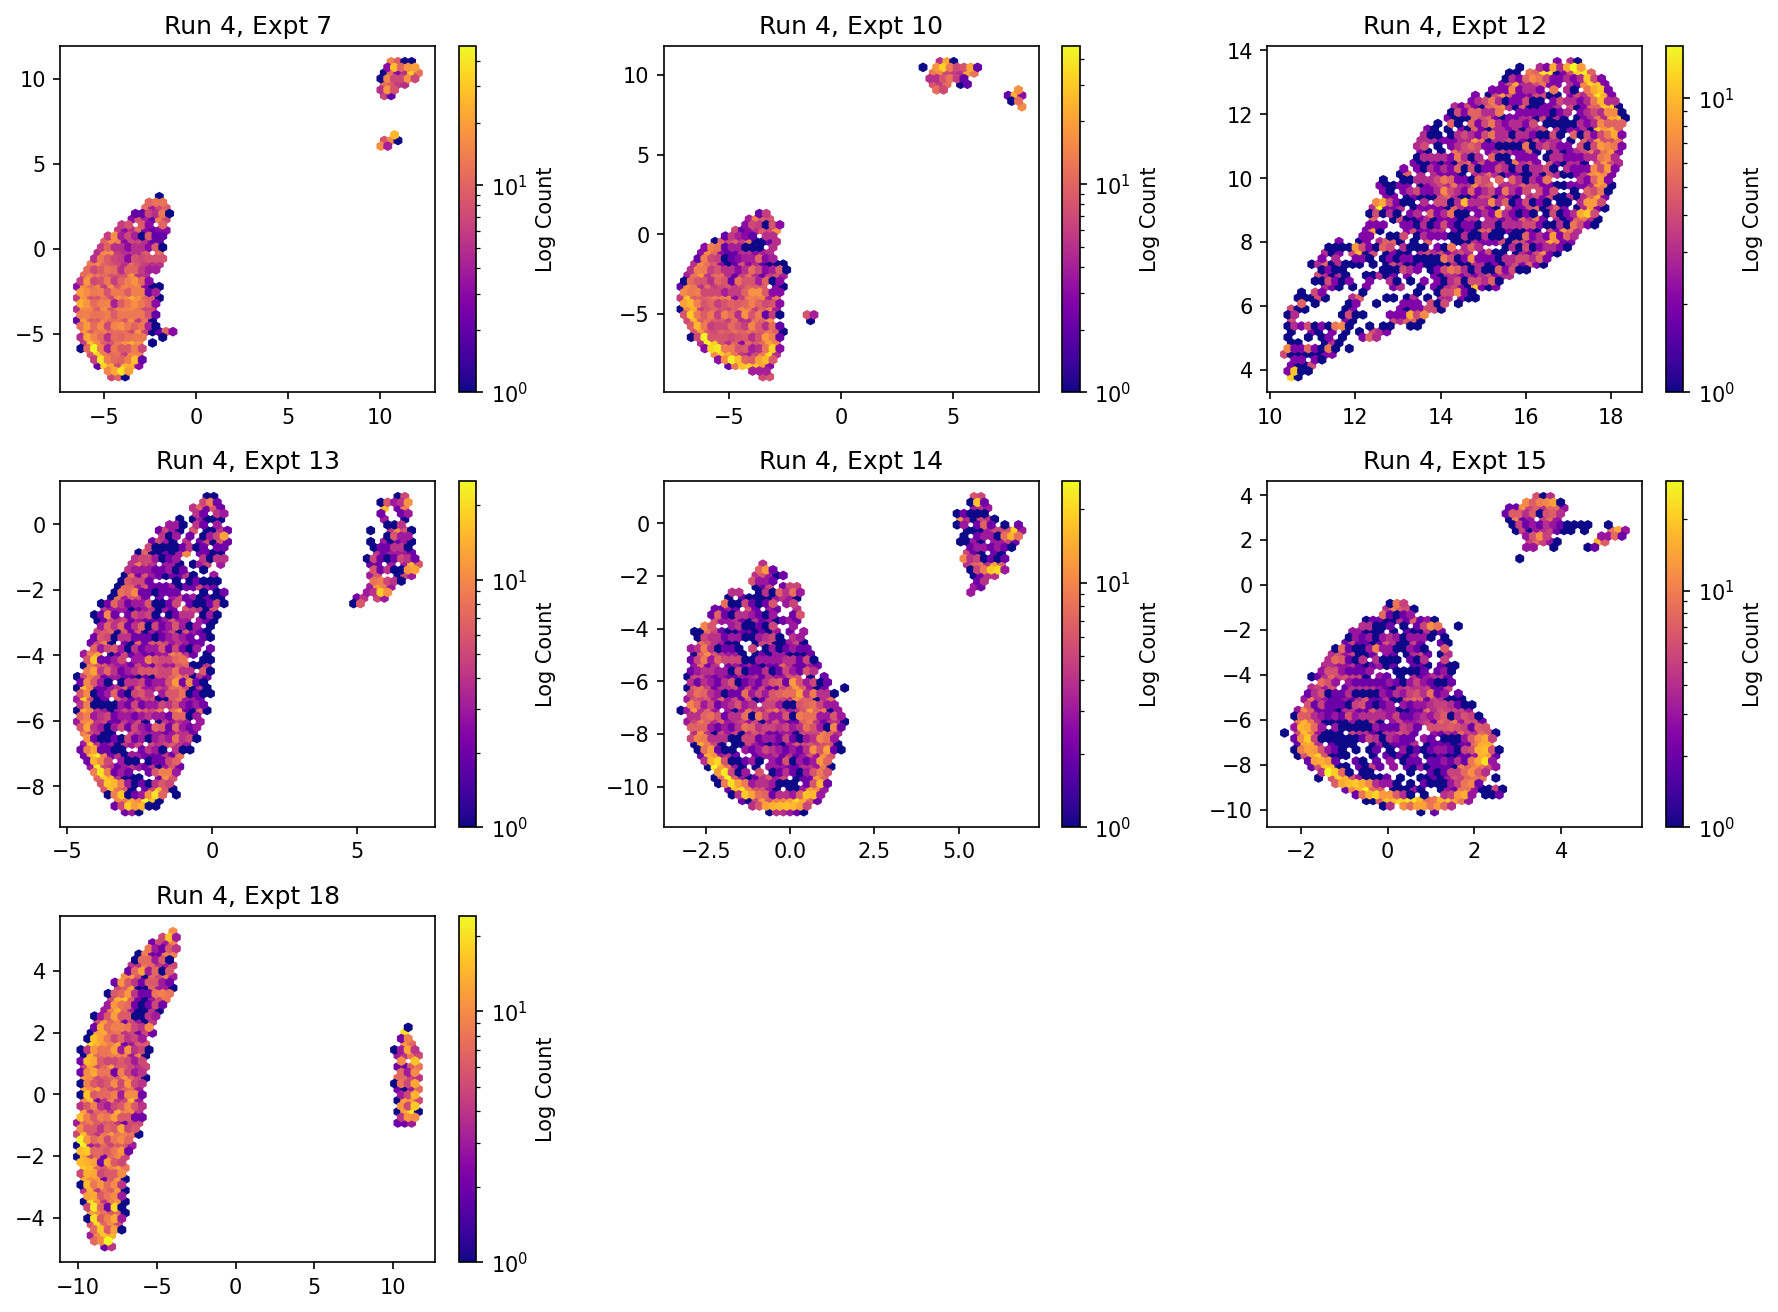

In [19]:
expts = [7,10,12,13,14,15,18]
runs = [4]*len(expts)
fig = plot_multiple_umaps(runs, expts, ncols=3, density=True, cmap='plasma',
                        suptitle=None,supress_hyrax_logs=True, log_colorbar=True, 
                        vmin=1)

  0%|          | 0/6 [00:00<?, ?it/s]

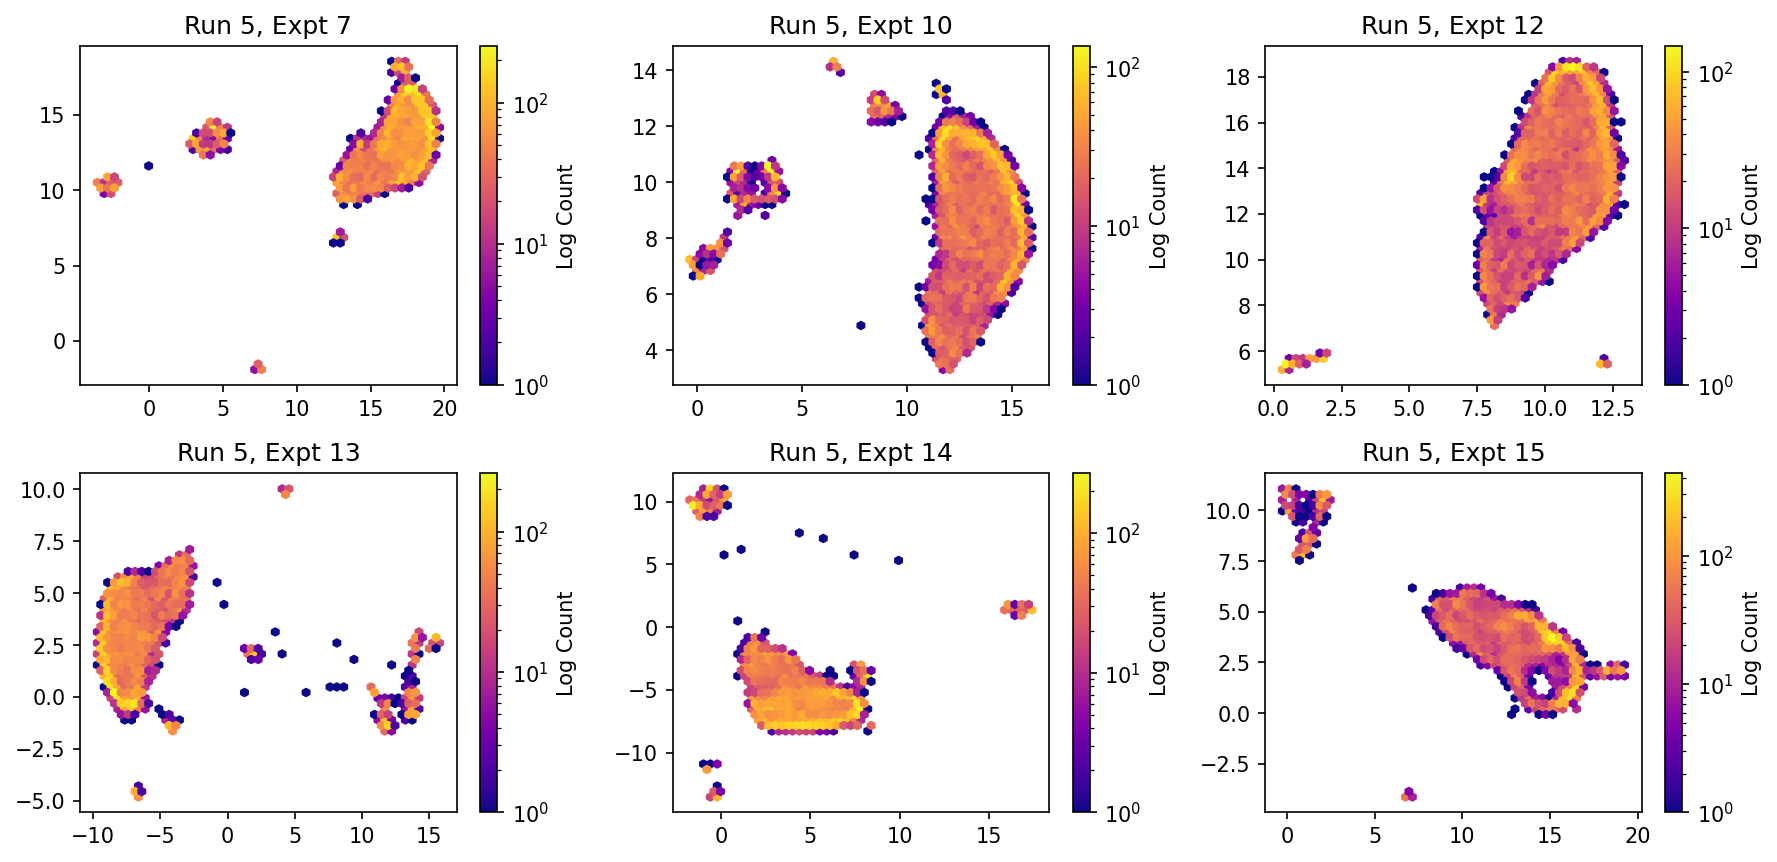

In [73]:
expts = [7,10,12,13,14,15]
runs = [5]*len(expts)
fig = plot_multiple_umaps(runs, expts, ncols=3, density=True, cmap='plasma',
                        suptitle=None,supress_hyrax_logs=True)

  0%|          | 0/6 [00:00<?, ?it/s]

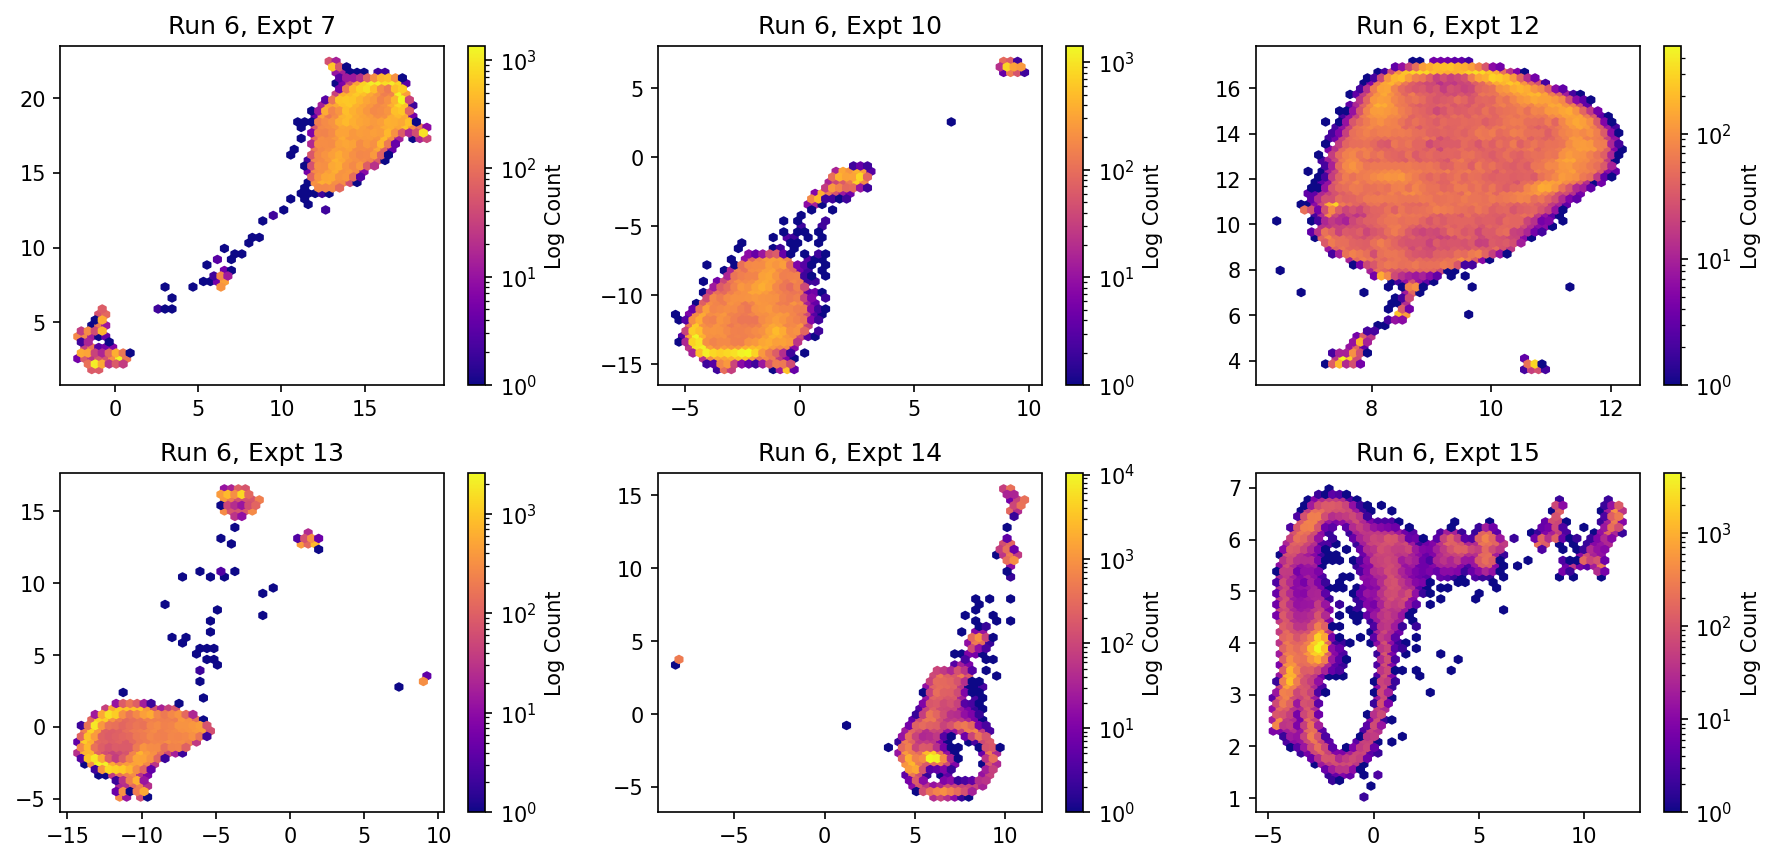

In [75]:
expts = [7,10,12,13,14,15]
runs = [6]*len(expts)
fig = plot_multiple_umaps(runs, expts, ncols=3, density=True, cmap='plasma',
                        suptitle=None,supress_hyrax_logs=True)

# ImageDCAE Runs

  0%|          | 0/8 [00:00<?, ?it/s]

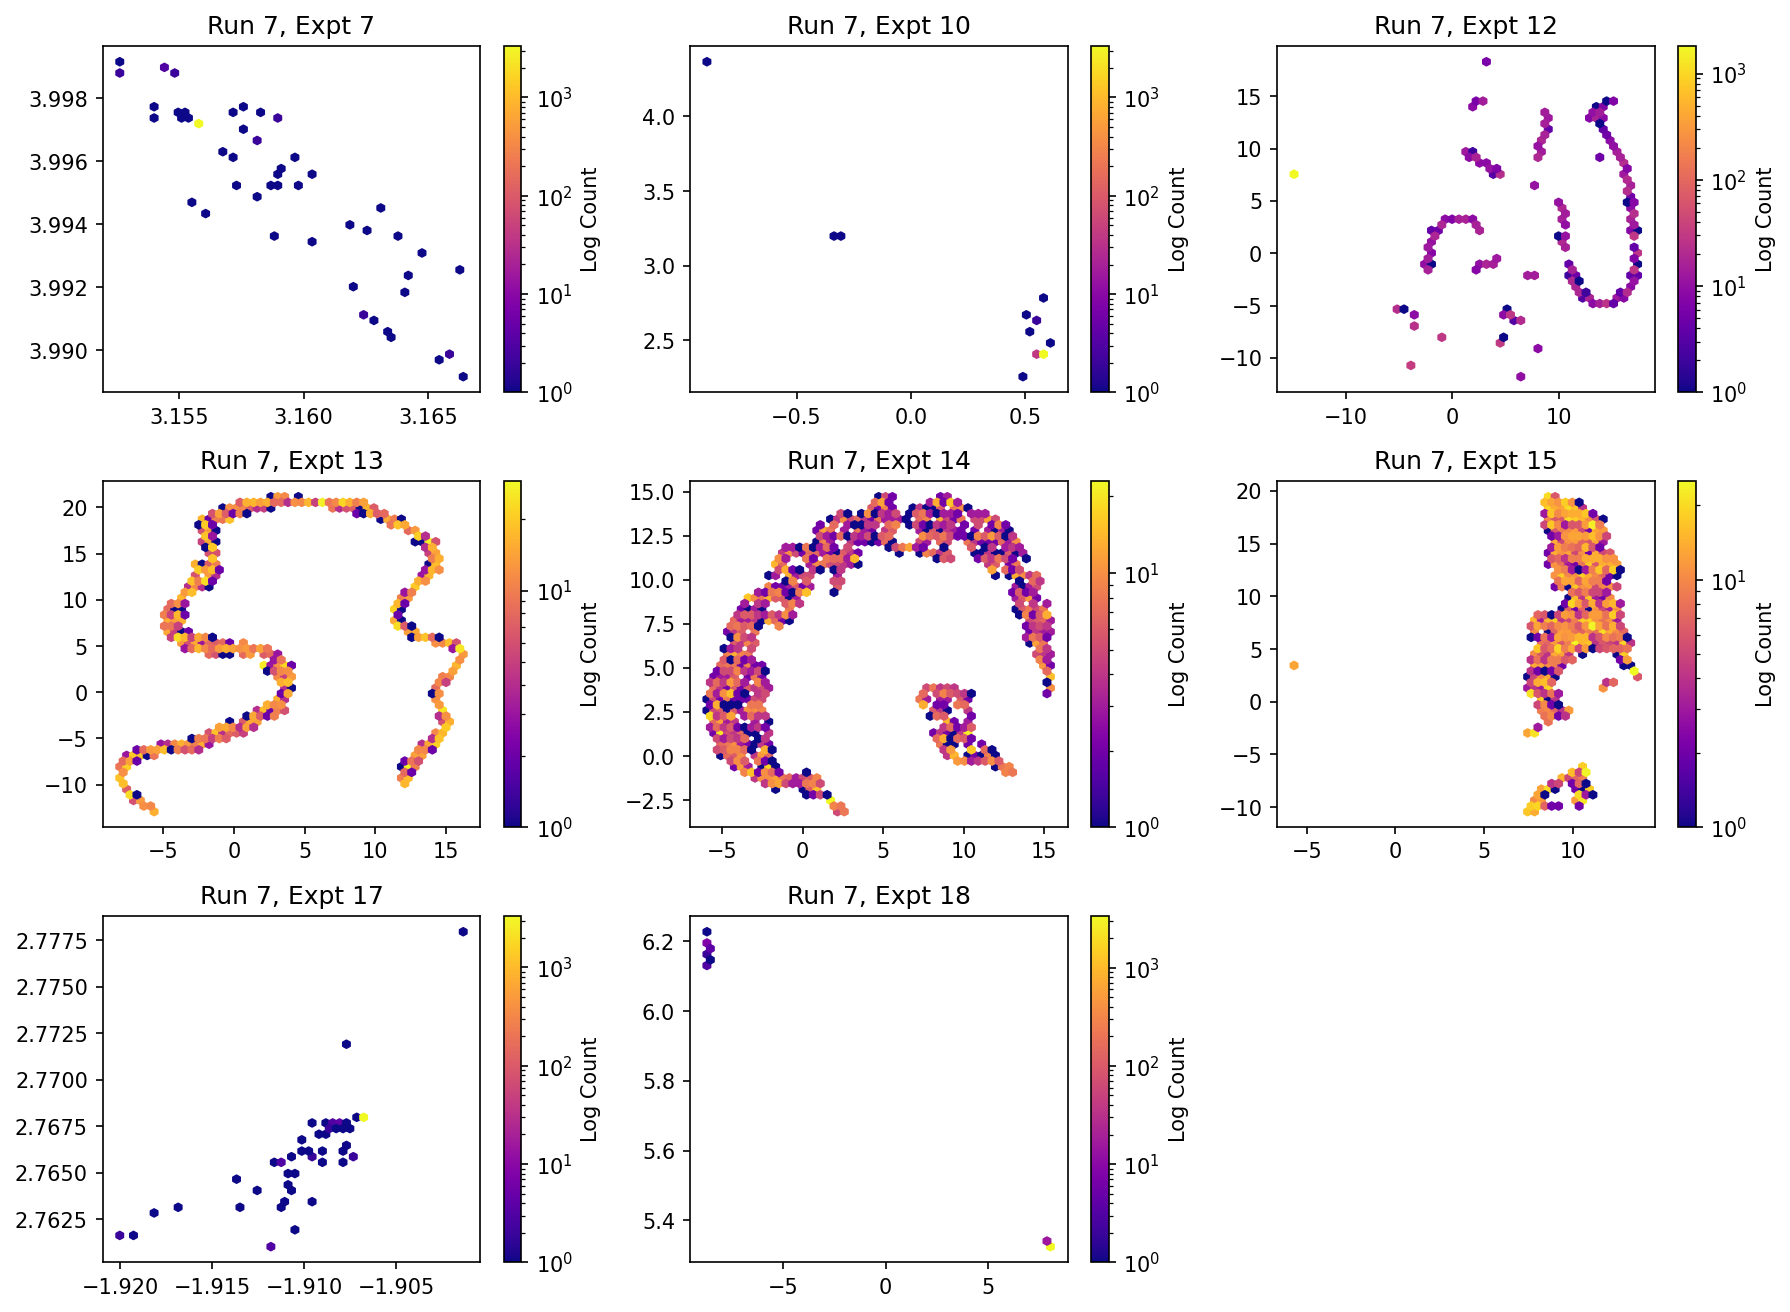

In [79]:
expts = [7,10,12,13,14,15,17,18]
runs = [7]*len(expts)
fig = plot_multiple_umaps(runs, expts, ncols=3, density=True, cmap='plasma',
                        suptitle=None,supress_hyrax_logs=True)

  0%|          | 0/7 [00:00<?, ?it/s]

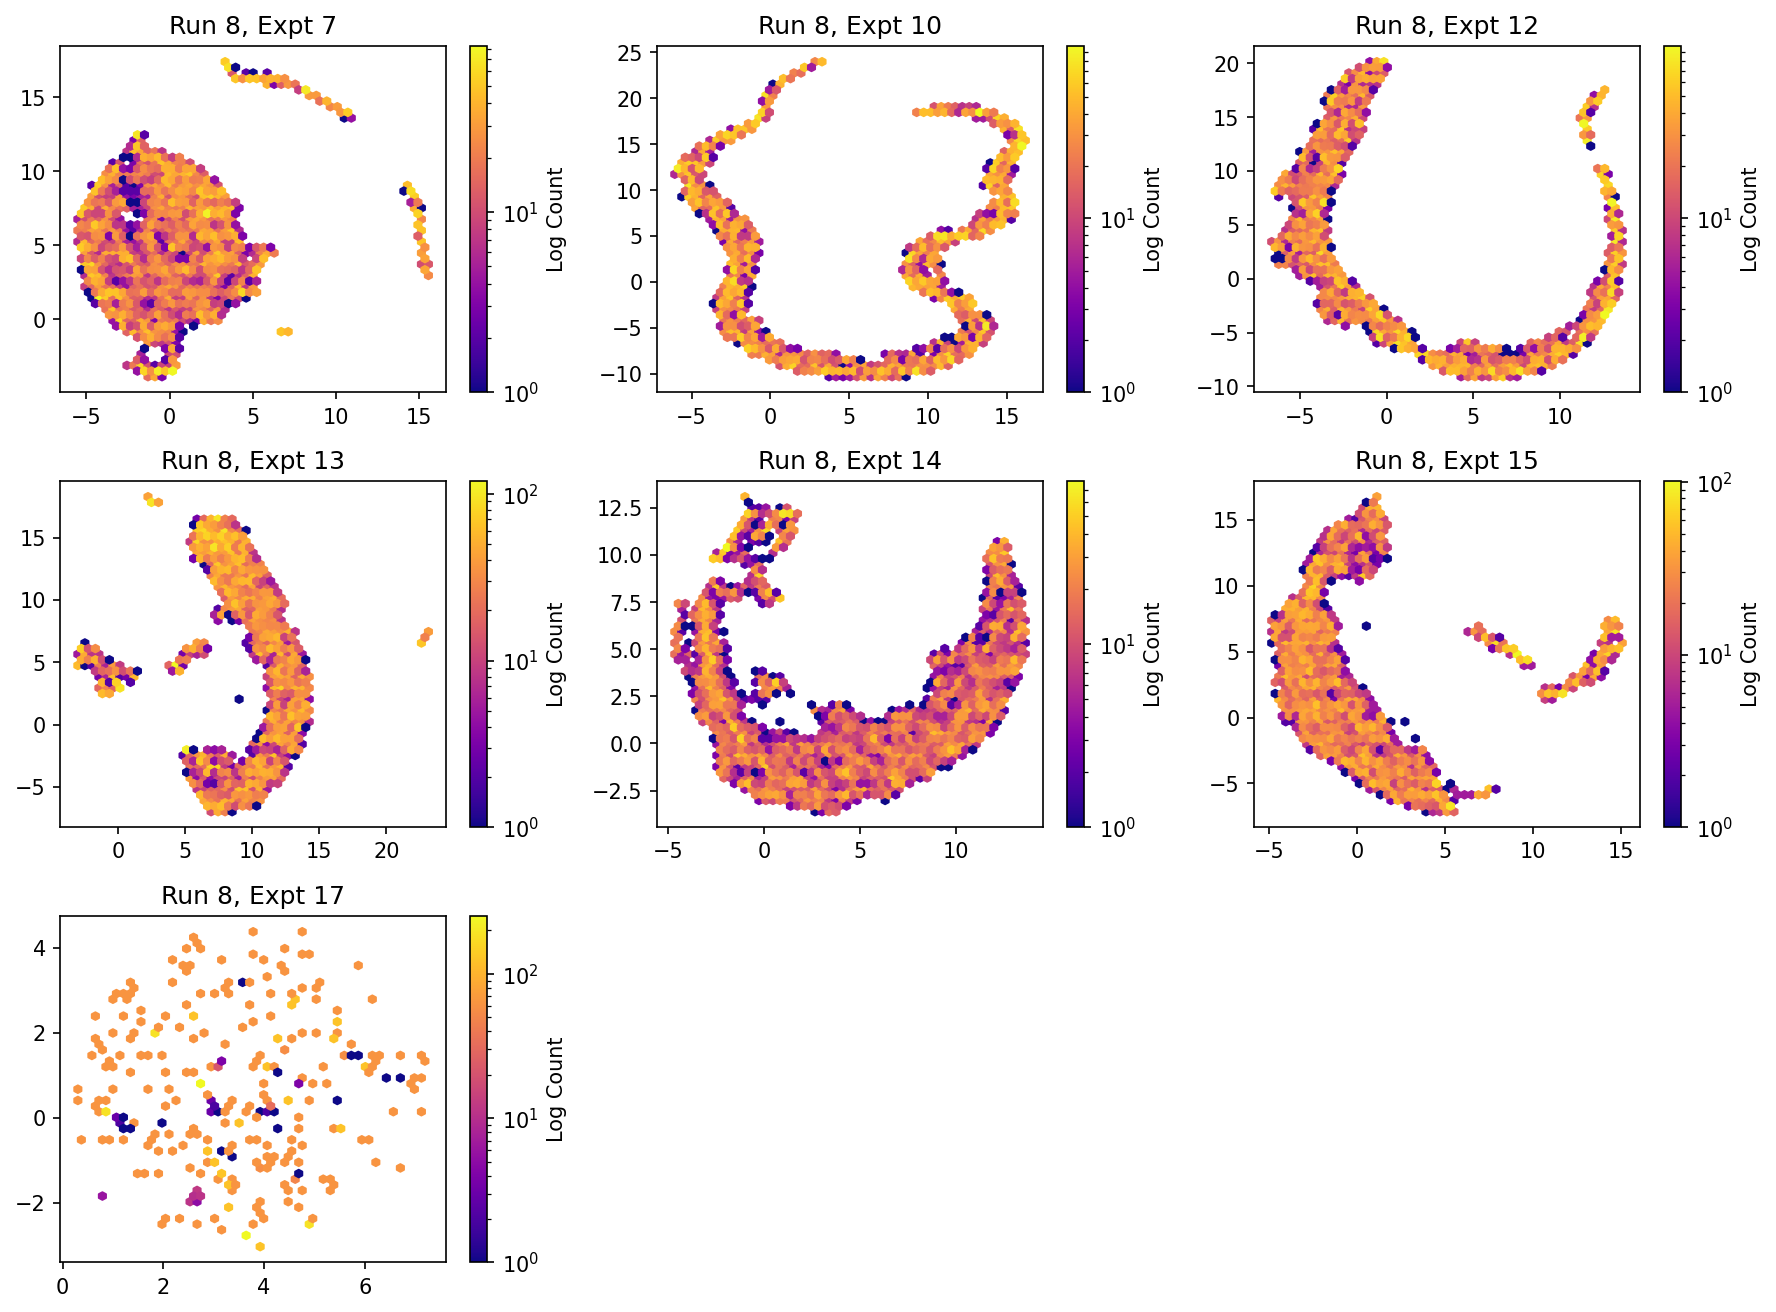

In [80]:
expts = [7,10,12,13,14,15,17]
runs = [8]*len(expts)
fig = plot_multiple_umaps(runs, expts, ncols=3, density=True, cmap='plasma',
                        suptitle=None,supress_hyrax_logs=True)

  0%|          | 0/7 [00:00<?, ?it/s]

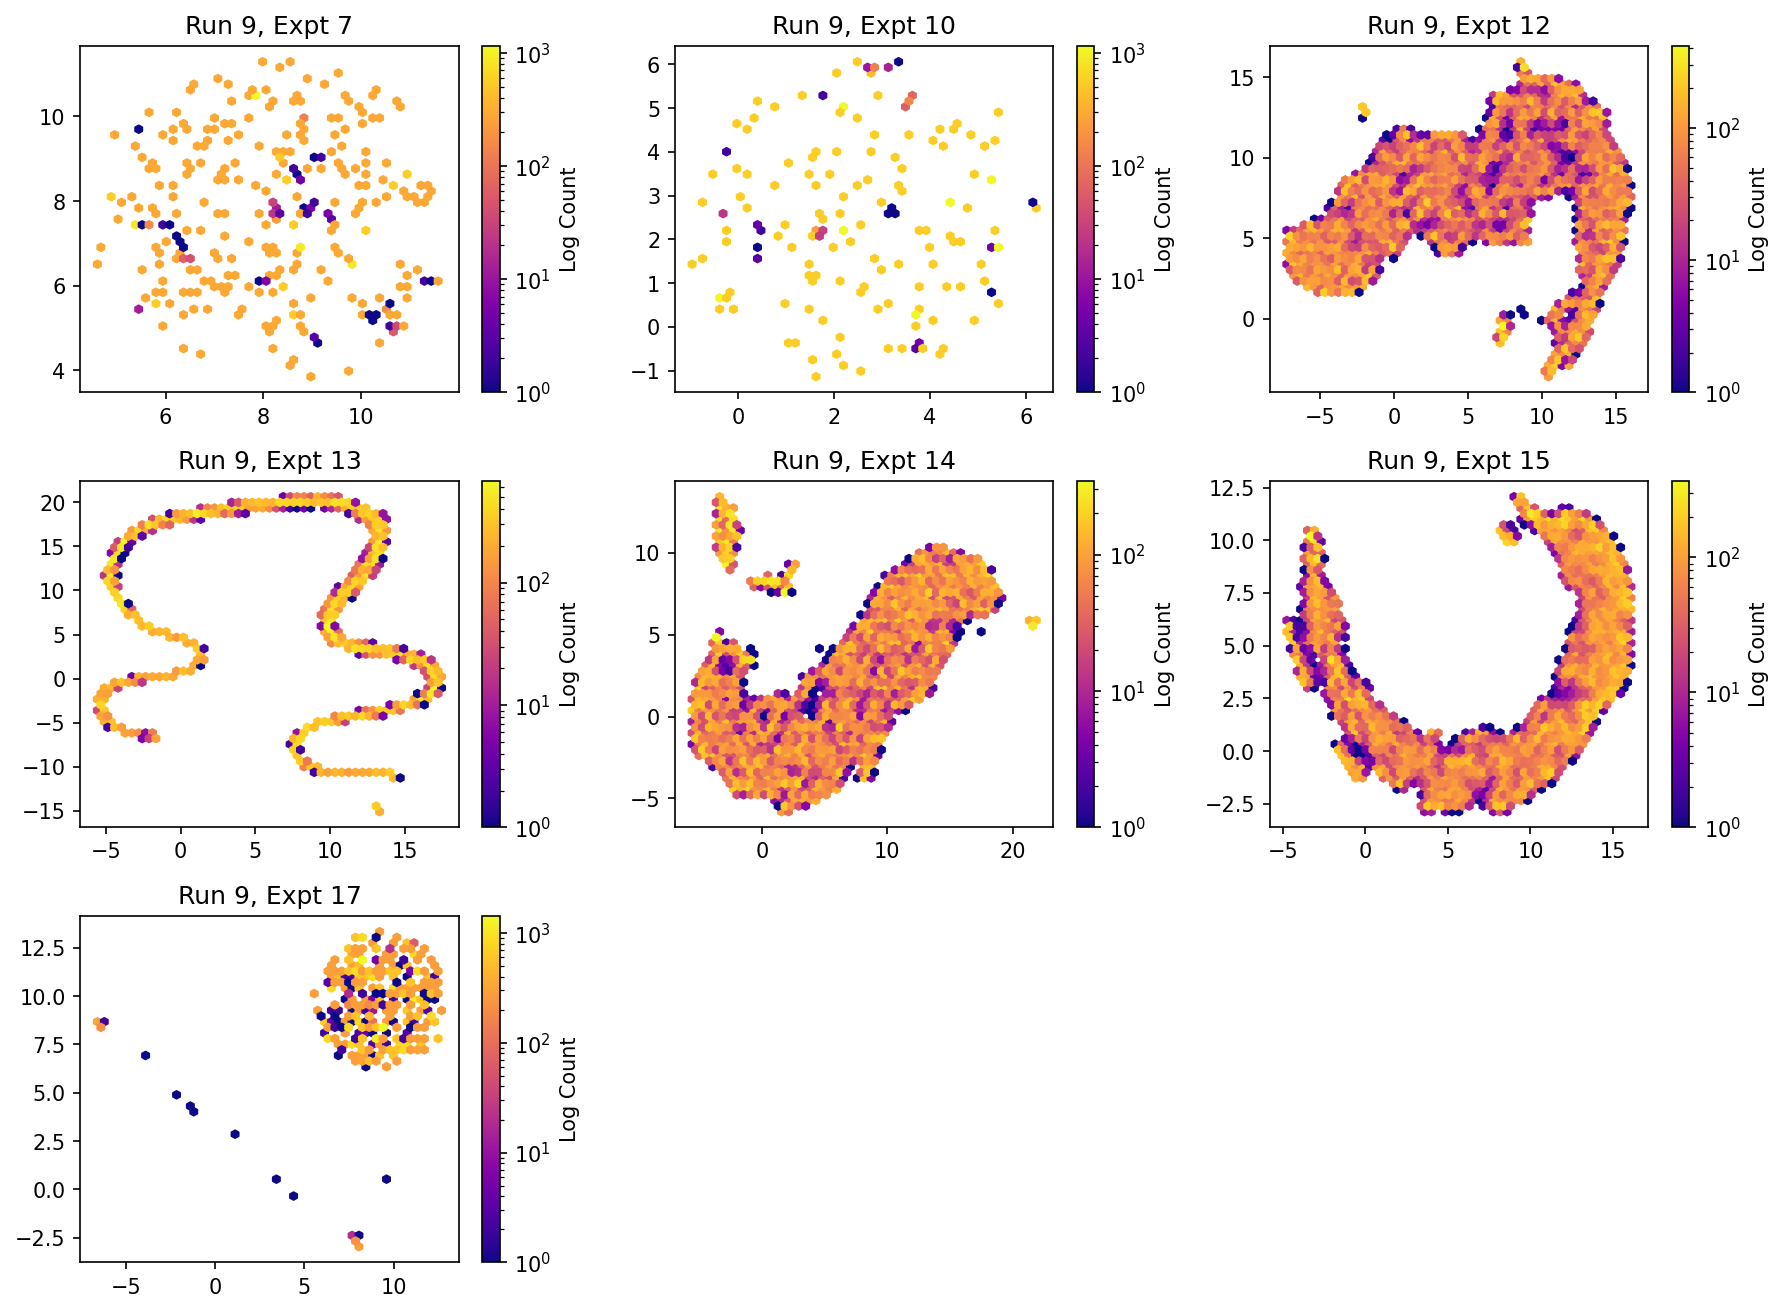

In [81]:
expts = [7,10,12,13,14,15,17]
runs = [9]*len(expts)
fig = plot_multiple_umaps(runs, expts, ncols=3, density=True, cmap='plasma',
                        suptitle=None,supress_hyrax_logs=True)